In [1]:
import scanpy as sc
import numpy as np
import anndata as ad

sc.settings.set_figure_params(dpi=50, facecolor="white")

In [2]:
data_path = "../../data/Tosches_turtle.h5ad"
adata = sc.read(data_path)
processed_data = np.nan_to_num(adata.X, nan=0.0)  # Replace NaN with 0.0
adata.X = processed_data

In [3]:
print(adata)

AnnData object with n_obs × n_vars = 18664 × 23500
    obs: 'cell_ontology_class', 'cell_ontology_id', 'cell_type1', 'dataset_name', 'donor', 'gender', 'organ', 'organism', 'platform', 'region', 'sample', 'celltype'
    uns: 'creation_date', 'source_file'


In [4]:
# QC
# Mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT")
# Ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))

sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo"], log1p=True, inplace=True)

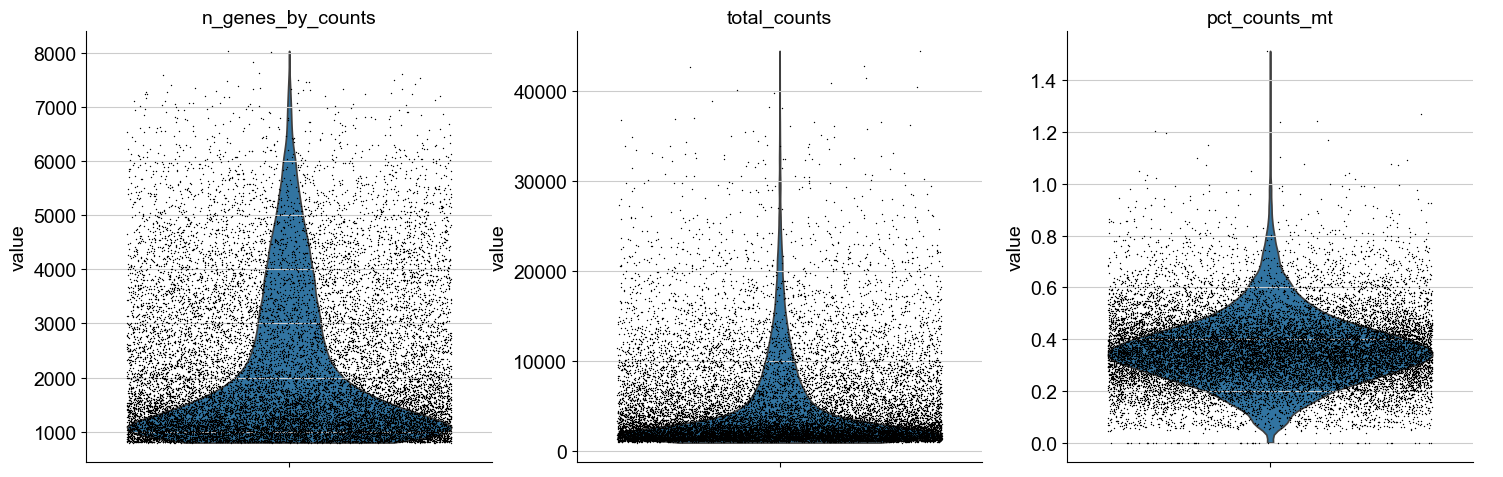

In [5]:
sc.pl.violin(adata, ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
             jitter=0.4, multi_panel=True, save="turtle.violin.png")

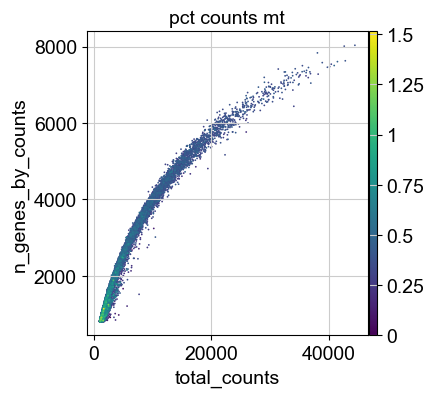

In [6]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [7]:
adata = adata[adata.obs.n_genes_by_counts < 6000, :]
adata = adata[adata.obs.pct_counts_mt < 1.0, :]
print(adata)

View of AnnData object with n_obs × n_vars = 18350 × 23500
    obs: 'cell_ontology_class', 'cell_ontology_id', 'cell_type1', 'dataset_name', 'donor', 'gender', 'organ', 'organism', 'platform', 'region', 'sample', 'celltype', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'creation_date', 'source_file'


In [8]:
# Normalization
# Saving count data
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

C:\Users\17619\AppData\Local\Temp\ipykernel_12852\32754451.py:3: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers["counts"] = adata.X.copy()


In [9]:
# Highly variable genes
adata.raw = adata # keep full dimension safe
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    flavor="seurat_v3",
    layer="counts",
    subset=True,
    # batch_key="batch"
)
print(adata)

AnnData object with n_obs × n_vars = 18350 × 2000
    obs: 'cell_ontology_class', 'cell_ontology_id', 'cell_type1', 'dataset_name', 'donor', 'gender', 'organ', 'organism', 'platform', 'region', 'sample', 'celltype', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'creation_date', 'source_file', 'log1p', 'hvg'
    layers: 'counts'


In [10]:
adata.write_h5ad("../../data/Tosches_turtle_processed.h5ad")